<a href="https://colab.research.google.com/github/vanessavvp/TFG-nerf-implementation/blob/main/tiny_nerf_lego.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Tiny NeRF
This is a simplied version of the method presented in *NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis*

[Project Website](http://www.matthewtancik.com/nerf)

[arXiv Paper](https://arxiv.org/abs/2003.08934)

[Full Code](github.com/bmild/nerf)

Components not included in the notebook
*   5D input including view directions
*   Hierarchical Sampling



In [3]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 1.x

import os, sys
import tensorflow as tf
# Eager execution provides an imperative interface to TensorFlow, tf functions execute operations immediately
tf.compat.v1.enable_eager_execution()

# Used for creating Progress Meters or Progress Bars
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


In [2]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

--2022-03-04 02:15:47--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2022-03-04 02:15:47--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  16.0MB/s    in 0.8s    

2022-03-04 02:15:48 (16.0 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]



# Load Input Images and Poses

Downloading...
From: https://drive.google.com/uc?id=1ZzkiCgHRI_gb-UIJT3dpdEl6HzkOpj-x
To: /content/r_0.png
100% 231k/231k [00:00<00:00, 65.2MB/s]
[[[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 ...

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]]


<function matplotlib.pyplot.show>

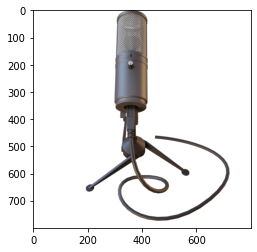

In [3]:
# https://drive.google.com/file/d/1ZzkiCgHRI_gb-UIJT3dpdEl6HzkOpj-x/view?usp=sharing
!gdown --id 1ZzkiCgHRI_gb-UIJT3dpdEl6HzkOpj-x
from PIL import Image
prueba = Image.open("r_0.png", "r").convert("RGBA")
data = np.asarray(prueba)
print(data)

plt.imshow(data)
plt.show

Files into data:  ['images', 'poses', 'focal']
First image content:  [0. 0. 0.]


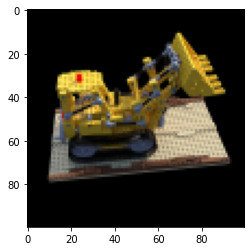

First pose content:  [[[-9.9990219e-01  4.1922452e-03 -1.3345719e-02 -5.3798322e-02]
  [-1.3988681e-02 -2.9965907e-01  9.5394367e-01  3.8454704e+00]
  [-4.6566129e-10  9.5403719e-01  2.9968831e-01  1.2080823e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]

 [[-9.3054223e-01  1.1707554e-01 -3.4696460e-01 -1.3986591e+00]
  [-3.6618456e-01 -2.9751042e-01  8.8170075e-01  3.5542498e+00]
  [ 7.4505806e-09  9.4751304e-01  3.1971723e-01  1.2888215e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]

 [[ 4.4296363e-01  3.1377721e-01 -8.3983749e-01 -3.3854935e+00]
  [-8.9653969e-01  1.5503149e-01 -4.1494811e-01 -1.6727095e+00]
  [ 0.0000000e+00  9.3675458e-01  3.4998694e-01  1.4108427e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]

 ...

 [[ 9.9999994e-01 -4.8568938e-07  9.2086310e-07  3.7121181e-06]
  [ 1.0410970e-06  4.6651685e-01 -8.8451219e-01 -3.5655830e+00]
  [ 2.8421709e-14  8.8451225e-01  4.6651685e-01  1.8805897e+00]
  [ 0.0

In [4]:
data = np.load('tiny_nerf_data.npz')
print("Files into data: ", data.files)

# Getting to know the images and poses format
print("First image content: ", data['images'][0][0][0]) # Images information
plt.imshow(data['images'][5])
plt.show()
print("First pose content: ", data['poses'])  # Camera x, y and z coordinates + rotation?? 
print("Focal content: ", data['focal']) # Focal lenght?? 


Images shape:  (106, 100, 100, 3) 
Poses shape:  (106, 4, 4) 
focal:  138.88887889922103

HEIGHT:  100 
WIDTH:  100
Images content:  [[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]


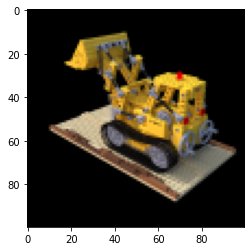


testPose


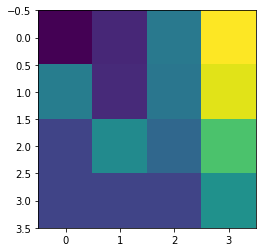

In [5]:
images = data['images']
poses = data['poses']
focal = data['focal']
HEIGHT, WIDTH = images.shape[1:3]
print("Images shape: ", images.shape, "\nPoses shape: ", poses.shape, "\nfocal: ", focal)
print("\nHEIGHT: ", HEIGHT, "\nWIDTH: ", WIDTH)

testImg, testPose = images[15], poses[15]
images = images[:100,...,:3] # ?
print("Images content: ", images)
poses = poses[:100]

print("\ntestImg")
plt.imshow(testImg)
plt.show()

print("\ntestPose")
plt.imshow(testPose)
plt.show()

# Optimize NeRF

In [5]:
def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 6
embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity

def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()    
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed)) 
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)
    outputs = dense(4, act=None)(outputs)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d



def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    def batchify(fn, chunk=1024*32):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    
    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples) 
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])
    
    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3]) 
    
    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    alpha = 1.-tf.exp(-sigma_a * dists)  
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
    
    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2) 
    depth_map = tf.reduce_sum(weights * z_vals, -1) 
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map

Here we optimize the model. We plot a rendered holdout view and its PSNR every 50 iterations.

0 2.1491537952423094 secs per iter


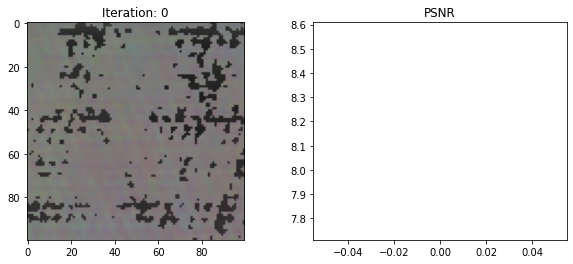

25 41.07347333908081 secs per iter


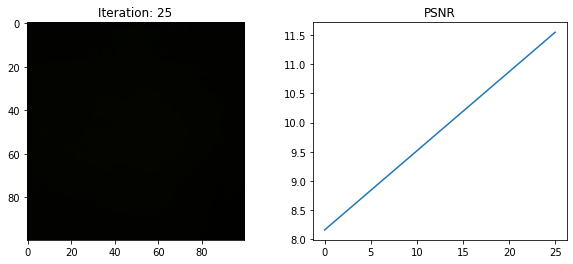

50 42.18235738754272 secs per iter


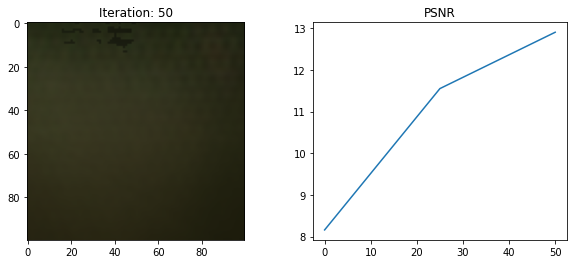

75 41.60471490859985 secs per iter


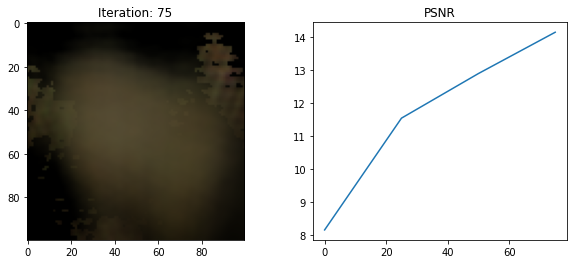

100 41.56251572608948 secs per iter


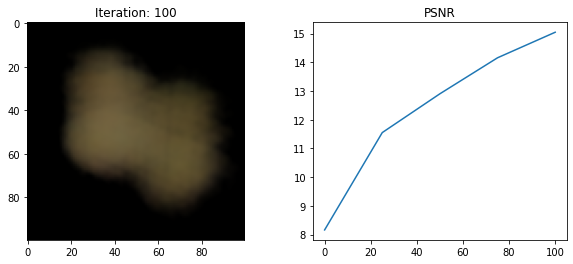

125 41.1160115814209 secs per iter


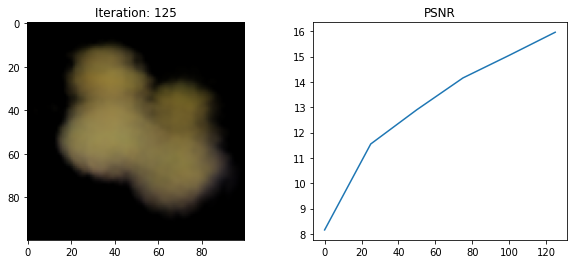

150 41.06733565330505 secs per iter


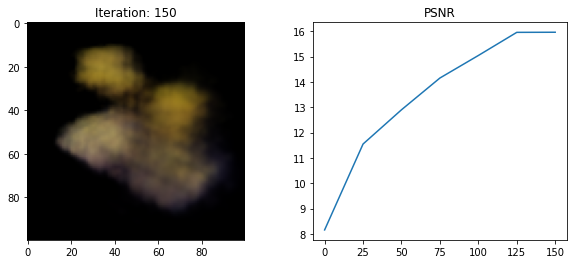

175 41.52344750404358 secs per iter


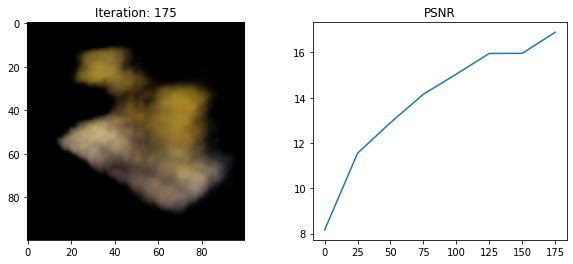

200 41.39090292930603 secs per iter


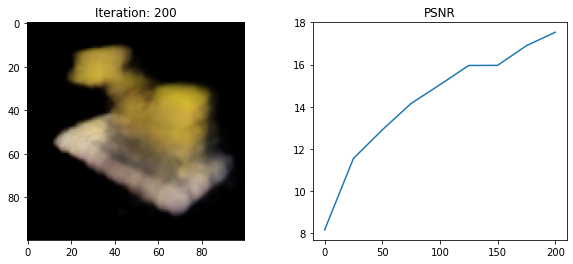

225 41.73902431488037 secs per iter


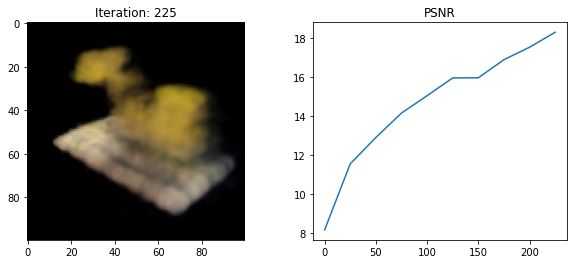

250 41.71740774154663 secs per iter


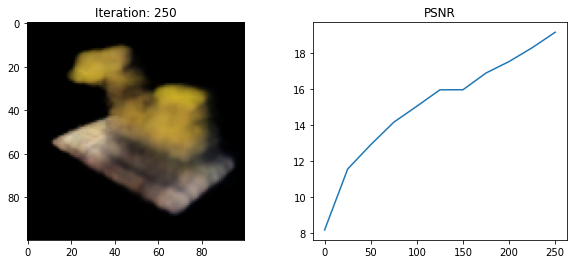

275 41.82298358917237 secs per iter


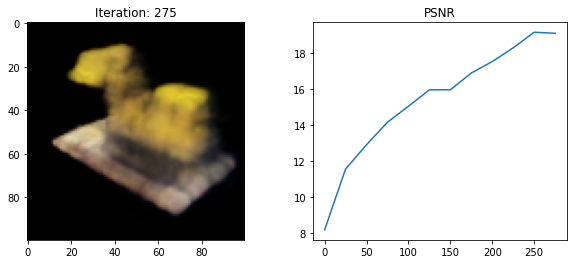

300 42.217462854385374 secs per iter


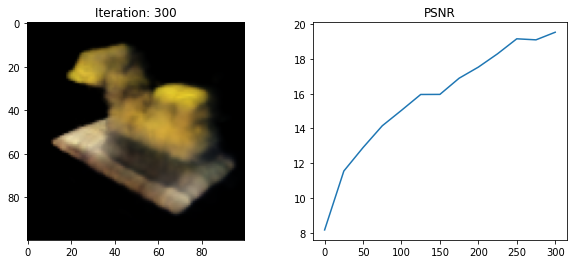

325 42.399265899658204 secs per iter


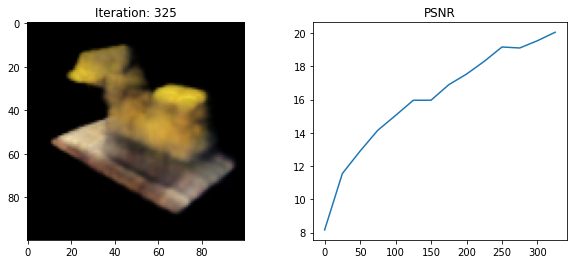

350 42.05734706878662 secs per iter


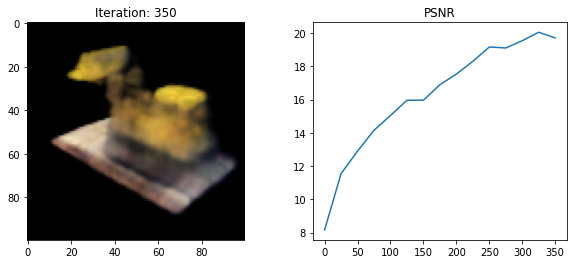

375 41.78437098503113 secs per iter


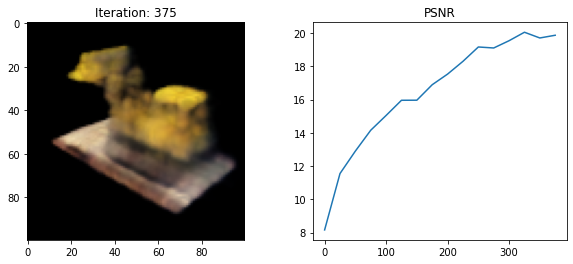

400 42.17544697761536 secs per iter


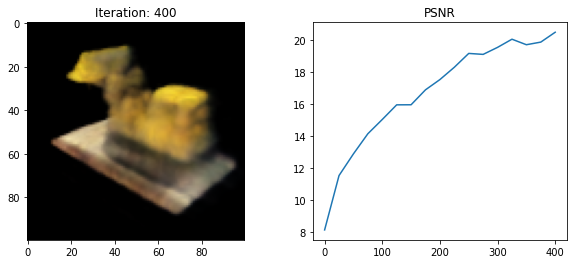

425 42.06163496017456 secs per iter


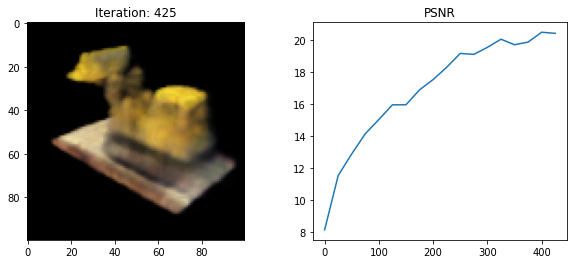

450 41.805060920715334 secs per iter


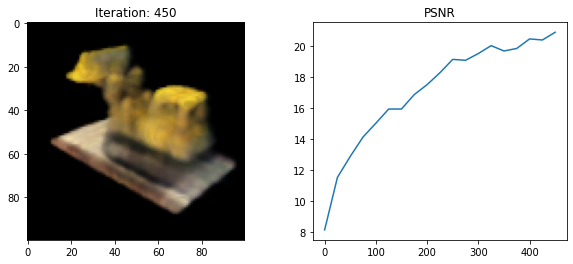

475 42.70263648033142 secs per iter


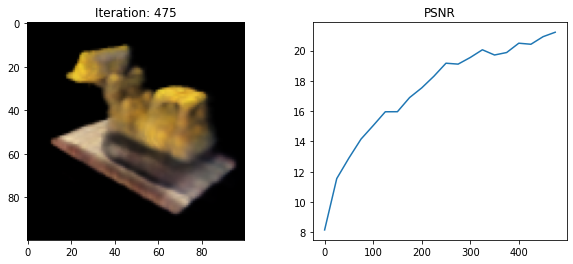

500 42.262497882843014 secs per iter


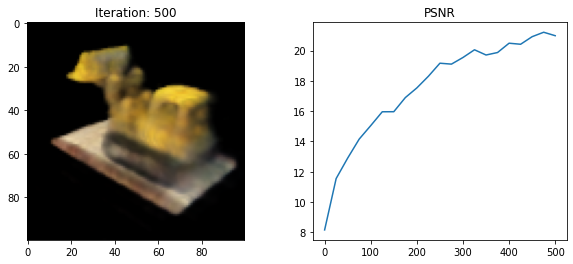

525 42.08141960144043 secs per iter


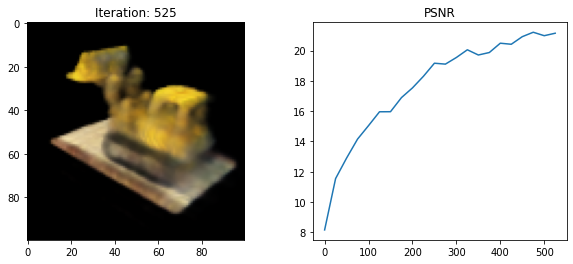

550 42.24063568115234 secs per iter


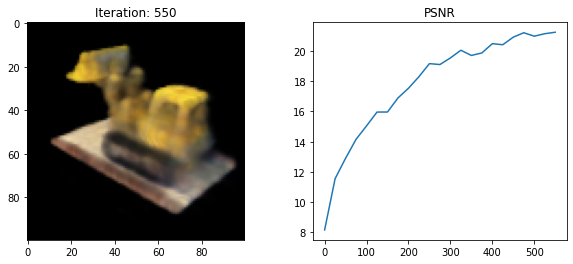

575 43.91946796417236 secs per iter


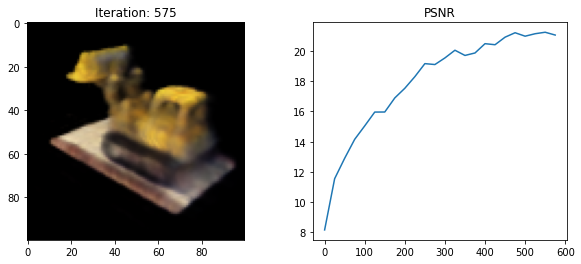

600 43.7993994808197 secs per iter


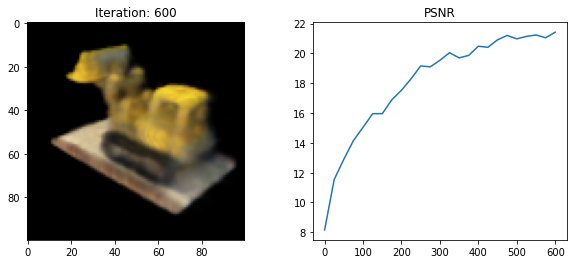

625 42.415551404953 secs per iter


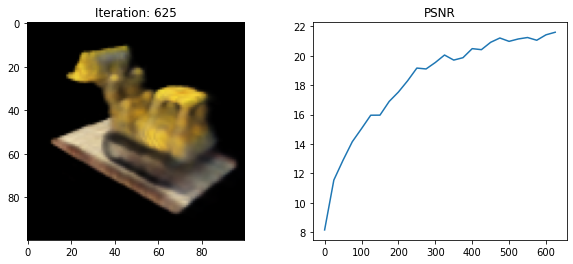

650 41.972025308609005 secs per iter


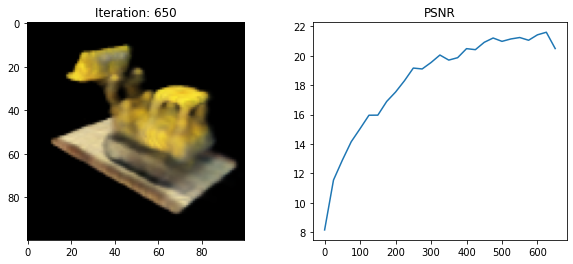

675 41.941792526245116 secs per iter


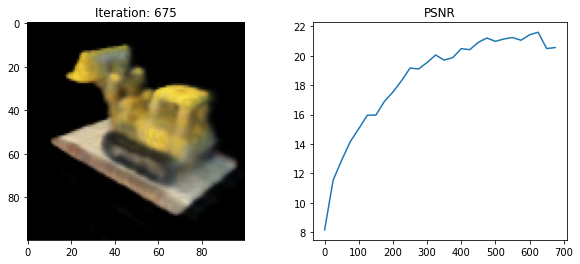

700 42.42703578948974 secs per iter


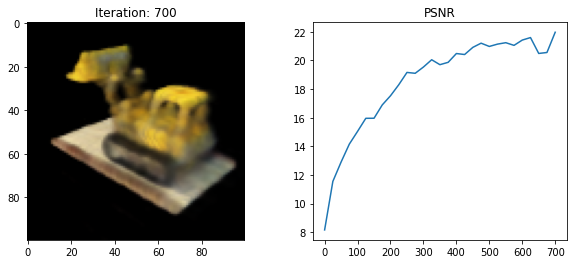

725 42.157578201293944 secs per iter


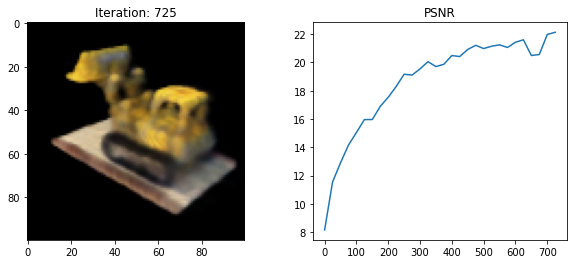

750 41.96778838157654 secs per iter


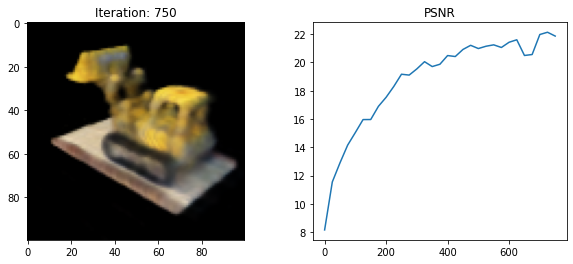

775 42.48161862373352 secs per iter


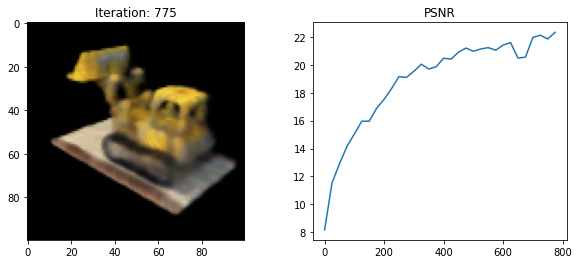

800 42.613442506790165 secs per iter


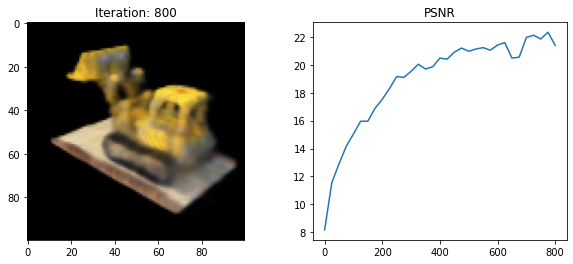

825 42.189214658737185 secs per iter


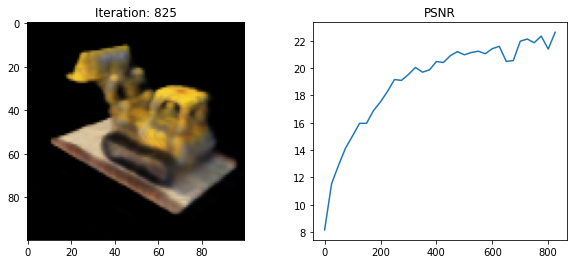

850 42.91361790657044 secs per iter


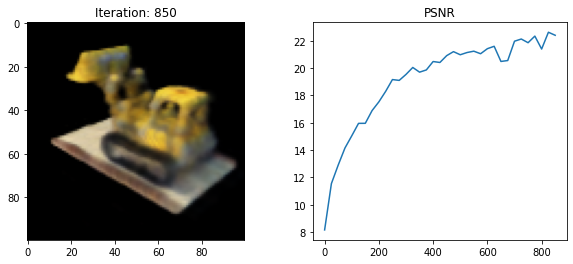

875 44.81100296974182 secs per iter


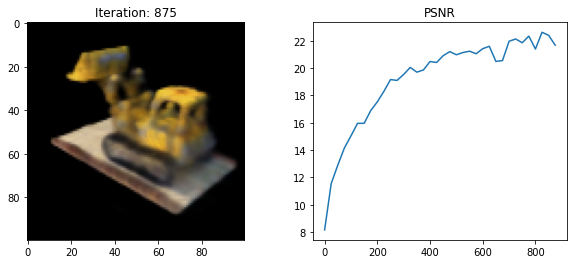

900 49.03399978637695 secs per iter


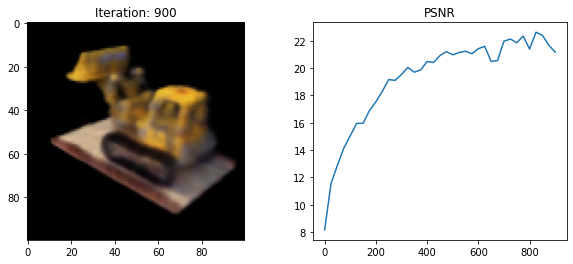

925 47.11429138183594 secs per iter


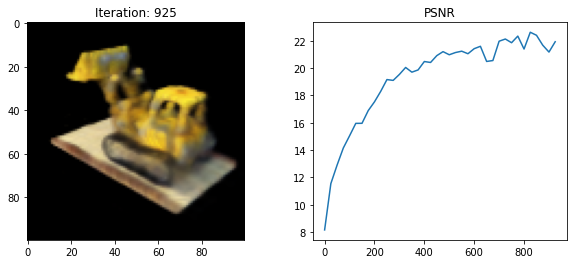

950 42.7611932849884 secs per iter


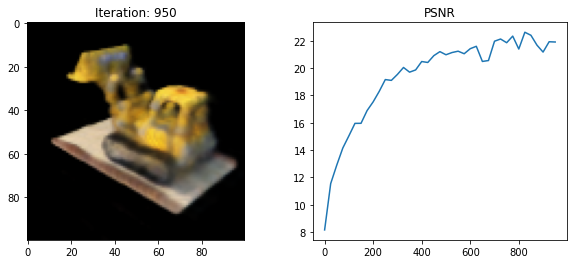

975 42.56843326568603 secs per iter


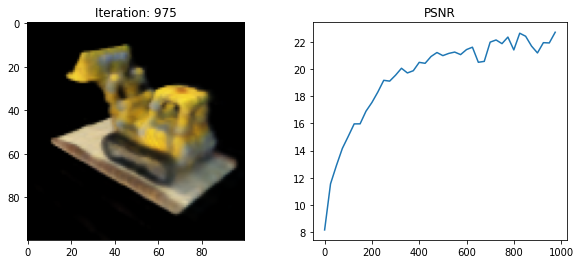

1000 43.18620440483093 secs per iter


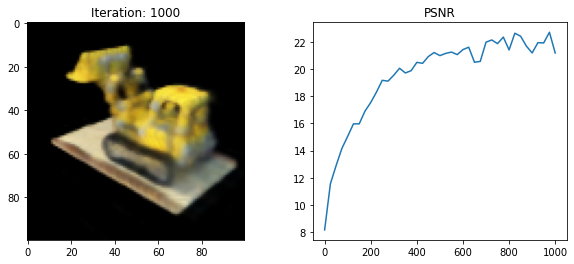

Done


In [7]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 64
N_iters = 1000
psnrs = []
iternums = []
i_plot = 25

import time
t = time.time()
for i in range(N_iters+1):
    
    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(HEIGHT, WIDTH, focal, pose)
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if i%i_plot==0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()
        
        # Render the holdout view for logging
        rays_o, rays_d = get_rays(HEIGHT, WIDTH, focal, testPose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testImg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)
        
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')

# Interactive Visualization

In [6]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(HEIGHT, WIDTH, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(rgb,0,1)
    
    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()
    

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

# Render 360 Video

In [1]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(HEIGHT, WIDTH, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

NameError: ignored

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)